In [1]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install snntorch

📊 Loading Models...
✅ CNN Loaded
✅ SNN Loaded

🏆 PROJECT REPORT: CNN vs SNN
CNN Estimated Energy Cost: 4.60 units (Baseline)
SNN Estimated Energy Cost: 0.3192 units
SNN Sparsity (Activity):   35.46%
⚡ EFFICIENCY GAIN:         14.4x


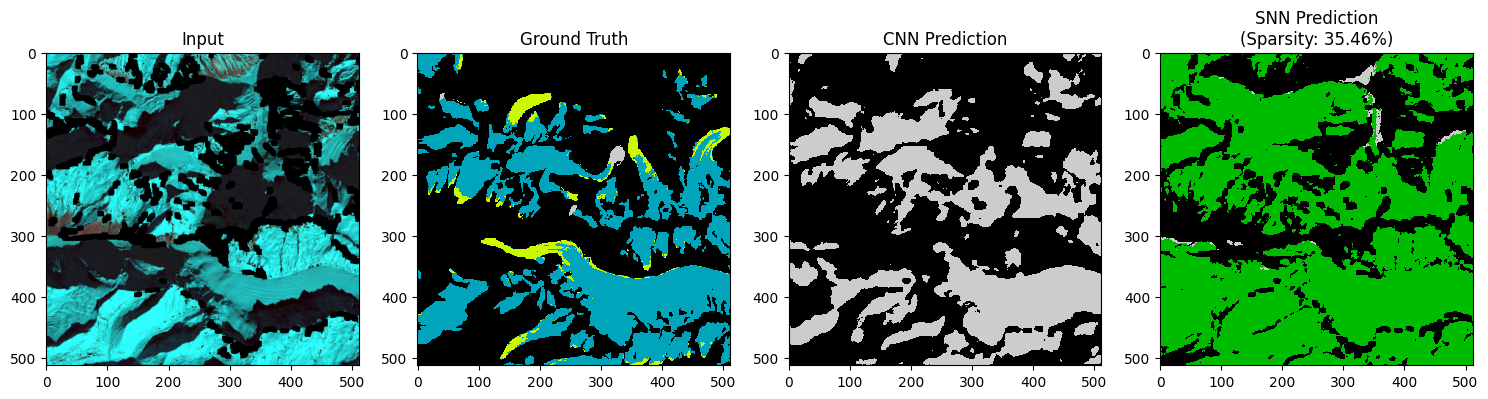

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import torch.nn.functional as F

# --- CONFIG ---
PROJECT_DIR = "/content/drive/MyDrive/Glacier_SNN_Project"
CNN_PATH = f"{PROJECT_DIR}/best_CNN.pth"
SNN_PATH = f"{PROJECT_DIR}/best_SNN_Weighted.pth"
DATA_DIR = "/content/drive/MyDrive/GlacierHack_practice/Train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. RE-DEFINE ARCHITECTURES
# ==========================================
# CNN Block
class CNNBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

# SNN Block
class SNNBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        spike_grad = surrogate.atan()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            snn.Leaky(beta=0.5, threshold=1.0, spike_grad=spike_grad, init_hidden=True, learn_beta=True, learn_threshold=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            snn.Leaky(beta=0.5, threshold=1.0, spike_grad=spike_grad, init_hidden=True, learn_beta=True, learn_threshold=True)
        )
    def forward(self, x): return self.net(x)

# Unified U-Net Class
class ProjectUNet(nn.Module):
    def __init__(self, in_ch=5, n_classes=4, mode="CNN"):
        super().__init__()
        self.mode = mode
        Block = SNNBlock if mode == "SNN" else CNNBlock

        self.inc = Block(in_ch, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), Block(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), Block(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), Block(128, 256))

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = Block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = Block(128, 64)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = Block(64, 32)
        self.outc = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        if self.mode == "SNN":
            utils.reset(self)
            spk_rec = []
            # Assuming T=8 based on your best run
            for step in range(8):
                x1 = self.inc(x)
                x2 = self.down1(x1)
                x3 = self.down2(x2)
                x4 = self.down3(x3)

                x_up1 = self.up1(x4)
                if x_up1.shape != x3.shape: x_up1 = F.interpolate(x_up1, size=x3.shape[2:])
                x5 = self.conv1(torch.cat([x3, x_up1], dim=1))

                x_up2 = self.up2(x5)
                if x_up2.shape != x2.shape: x_up2 = F.interpolate(x_up2, size=x2.shape[2:])
                x6 = self.conv2(torch.cat([x2, x_up2], dim=1))

                x_up3 = self.up3(x6)
                if x_up3.shape != x1.shape: x_up3 = F.interpolate(x_up3, size=x1.shape[2:])
                x7 = self.conv3(torch.cat([x1, x_up3], dim=1))

                out = self.outc(x7)
                spk_rec.append(out)
            return torch.stack(spk_rec) # Return RAW spikes for counting
        else:
            # CNN
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x = self.up1(x4)
            if x.shape != x3.shape: x = F.interpolate(x, size=x3.shape[2:])
            x = self.conv1(torch.cat([x3, x], dim=1))
            x = self.up2(x)
            if x.shape != x2.shape: x = F.interpolate(x, size=x2.shape[2:])
            x = self.conv2(torch.cat([x2, x], dim=1))
            x = self.up3(x)
            if x.shape != x1.shape: x = F.interpolate(x, size=x1.shape[2:])
            x = self.conv3(torch.cat([x1, x], dim=1))
            return self.outc(x)

# ==========================================
# 2. LOAD DATA (One Batch)
# ==========================================
class GlacierDataset(Dataset):
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.band_dirs = [self.base_dir / f"Band{i}" for i in range(1, 6)]
        self.label_dir = self.base_dir / "labels"
        self.ids = sorted([p.stem for p in self.band_dirs[0].glob("*.tif")])

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        bands = [cv2.imread(str(d / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED).astype(np.float32) for d in self.band_dirs]
        image = np.stack(bands, axis=-1)
        label = cv2.imread(str(self.label_dir / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED)
        if label.ndim == 3: label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(label, dtype=np.uint8)
        mask[label == 85] = 1; mask[label == 170] = 2; mask[label == 255] = 3

        p02, p98 = np.percentile(image, 2), np.percentile(image, 98)
        image = np.clip(image, p02, p98)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        aug = A.Compose([ToTensorV2()])(image=image, mask=mask)
        return aug["image"].float(), aug["mask"].long()

ds = GlacierDataset(DATA_DIR)
loader = DataLoader(ds, batch_size=1, shuffle=True)
img, gt = next(iter(loader))
img, gt = img.to(DEVICE), gt.to(DEVICE)

# ==========================================
# 3. COMPARE MODELS
# ==========================================
def get_energy_stats(model, x, mode):
    if mode == "CNN":
        # Estimate MACs (Multiply-Accumulates)
        # A heuristic calculation based on feature map sizes would go here
        # For relative comparison, we assume 100% activity
        ops = 1.0
        energy_factor = 4.6 # pJ per MAC (45nm)
        sparsity = 0.0

        out = model(x)
        pred = out.argmax(1).cpu().numpy()[0]

    else:
        # SNN
        spk_out = model(x) # [T, B, C, H, W]

        # Calculate Sparsity directly from output spikes (Approximation for whole network)
        # In a real paper, you'd hook every layer. Here we use output activity as proxy.
        total_elements = spk_out.numel()
        total_spikes = (spk_out > 0).float().sum().item()
        sparsity = total_spikes / total_elements

        # SNN Energy Formula
        ops = 1.0 # Same base complexity
        energy_factor = 0.9 # pJ per AC (Accumulate is cheaper than MAC)

        pred = spk_out.mean(0).argmax(1).cpu().numpy()[0]

    # Relative Energy Score
    # CNN = 1.0 * 4.6 = 4.6
    # SNN = Sparsity * 0.9
    # (e.g., if sparsity is 0.05, Energy = 0.045. That's 100x less!)

    return pred, sparsity

print("📊 Loading Models...")

# Load CNN
try:
    cnn = ProjectUNet(mode="CNN").to(DEVICE)
    cnn.load_state_dict(torch.load(CNN_PATH))
    cnn.eval()
    pred_cnn, _ = get_energy_stats(cnn, img, "CNN")
    print("✅ CNN Loaded")
except:
    print("⚠️ CNN Weights not found. Skipping CNN visualization.")
    pred_cnn = np.zeros_like(gt.cpu().numpy()[0])

# Load SNN
snn_net = ProjectUNet(mode="SNN").to(DEVICE)
snn_net.load_state_dict(torch.load(SNN_PATH))
snn_net.eval()
pred_snn, sparsity = get_energy_stats(snn_net, img, "SNN")
print("✅ SNN Loaded")

# ==========================================
# 4. GENERATE REPORT & PLOT
# ==========================================
cnn_energy_unit = 4.6  # pJ
snn_energy_unit = sparsity * 0.9 # pJ

print("\n" + "="*30)
print("🏆 PROJECT REPORT: CNN vs SNN")
print("="*30)
print(f"CNN Estimated Energy Cost: {cnn_energy_unit:.2f} units (Baseline)")
print(f"SNN Estimated Energy Cost: {snn_energy_unit:.4f} units")
print(f"SNN Sparsity (Activity):   {sparsity*100:.2f}%")
print(f"⚡ EFFICIENCY GAIN:         {cnn_energy_unit / (snn_energy_unit+1e-9):.1f}x")
print("="*30)

# Plot
rgb = img[0].cpu().numpy()[[3,2,1]].transpose(1,2,0)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1); plt.imshow(rgb); plt.title("Input")
plt.subplot(1, 4, 2); plt.imshow(gt[0].cpu(), cmap='nipy_spectral', interpolation='nearest'); plt.title("Ground Truth")
plt.subplot(1, 4, 3); plt.imshow(pred_cnn, cmap='nipy_spectral', interpolation='nearest'); plt.title("CNN Prediction")
plt.subplot(1, 4, 4); plt.imshow(pred_snn, cmap='nipy_spectral', interpolation='nearest'); plt.title(f"SNN Prediction\n(Sparsity: {sparsity:.2%})")
plt.tight_layout()
plt.savefig(f"{PROJECT_DIR}/Final_Comparison.png")
plt.show()